<a href="https://colab.research.google.com/github/bt22dr/PRML/blob/master/PRML_chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Linear Models for Regression

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-rc1

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
import math
import matplotlib.pyplot as plt

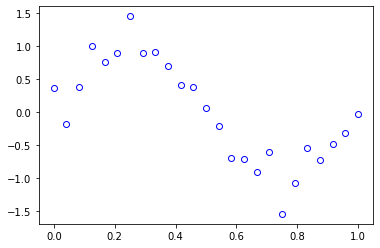

In [2]:
# 참고: https://github.com/ctgk/PRML
import numpy as np

def sinusoidal(x):
  return np.sin(2 * np.pi * x)

def linear(x):
  return -0.3 + 0.5 * x

def cubic(x):
  return x * (x - 5) * (x + 5)

def create_toy_data(func, sample_size, std, domain=[0, 1]):
  x = np.linspace(domain[0], domain[1], sample_size)
  np.random.shuffle(x)
  t = func(x) + np.random.normal(scale=std, size=x.shape)
  return x, t

x, y = create_toy_data(sinusoidal, 25, 0.25)
plt.plot(x, y, 'bo', markerfacecolor='none')


# def create_toy_data(func, sample_size, std, domain=[0.0, 1.0]):
#   x = tf.linspace(domain[0], domain[1], sample_size)
#   t = func(x) + tf.random.normal(x.shape, stddev=std)
#   return x, t

# def sinusoidal(x):
#   return tf.math.sin(2 * math.pi * x)

# def linear(x):
#   return -0.3 + 0.5 * x

# def cubic(x):
#   return x * (x - 5) * (x + 5)  

# x, y = create_toy_data(sinusoidal, 25, 0.25)
# plt.plot(x, y, 'bo', markerfacecolor='none')

## 3.1. Linear Basis Function Models

In [3]:
def polynomial_basis_functions(x, M):
  X = []
  for i in range(M):
    X.append(tf.math.pow(x, i))
  return tf.transpose(tf.stack(X))

print(polynomial_basis_functions(0.5, 4))
print(polynomial_basis_functions([-0.5, 0.0, 0.5], 6))

tf.Tensor([1.    0.5   0.25  0.125], shape=(4,), dtype=float32)
tf.Tensor(
[[ 1.      -0.5      0.25    -0.125    0.0625  -0.03125]
 [ 1.       0.       0.       0.       0.       0.     ]
 [ 1.       0.5      0.25     0.125    0.0625   0.03125]], shape=(3, 6), dtype=float32)


In [4]:
def gaussian_basis_functions(x, mu, s):
  X = []
  for m in mu:
    X.append(
        tf.math.exp(-0.5 * tf.math.pow(tf.subtract(x, m), 2) / s**2)) # 식 3.4
  return tf.transpose(tf.stack(X))

mu, s = tf.linspace(-1.0, 1.0, 6), 0.1
print(gaussian_basis_functions(0.5, mu, s))
print(gaussian_basis_functions([-0.5, 0.0, 0.5], mu, s))

tf.Tensor(
[0.0000000e+00 5.3110719e-27 2.2897349e-11 1.1109012e-02 6.0653049e-01
 3.7266532e-06], shape=(6,), dtype=float32)
tf.Tensor(
[[3.7266532e-06 6.0653049e-01 1.1108992e-02 2.2897260e-11 5.3110719e-27
  0.0000000e+00]
 [1.9287499e-22 1.5229951e-08 1.3533531e-01 1.3533515e-01 1.5229951e-08
  1.9287499e-22]
 [0.0000000e+00 5.3110719e-27 2.2897349e-11 1.1109012e-02 6.0653049e-01
  3.7266532e-06]], shape=(3, 6), dtype=float32)


In [5]:
def sigmoidal_basis_functions(x, mu, s):
  X = []
  for m in mu:
    X.append(
        tf.math.sigmoid(tf.subtract(x, m) / s)) # 식 3.5
  return tf.transpose(tf.stack(X))

mu, s = tf.linspace(-1.0, 1.0, 6), 0.1
print(sigmoidal_basis_functions(0.5, mu, s))
print(sigmoidal_basis_functions([-0.5, 0.0, 0.5], mu, s))

tf.Tensor([0.99999964 0.9999833  0.999089   0.95257413 0.26894137 0.00669285], shape=(6,), dtype=float32)
tf.Tensor(
[[9.9330717e-01 7.3105860e-01 4.7425874e-02 9.1105077e-04 1.6701422e-05
  3.0590223e-07]
 [9.9995458e-01 9.9752742e-01 8.8079703e-01 1.1920288e-01 2.4726230e-03
  4.5397872e-05]
 [9.9999964e-01 9.9998331e-01 9.9908900e-01 9.5257413e-01 2.6894137e-01
  6.6928510e-03]], shape=(3, 6), dtype=float32)


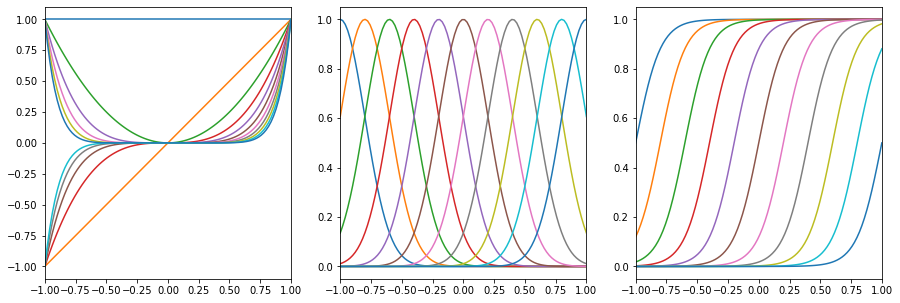

In [6]:
M = 11
mu = tf.linspace(-1.0, 1.0, M)
x = tf.linspace(-1.0, 1.0, 100)

X_polynomial = polynomial_basis_functions(x, M)
X_gaussian = gaussian_basis_functions(x, mu, 0.2)
X_sigmoidal = sigmoidal_basis_functions(x, mu, 0.1)

plt.figure(figsize=(15, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
  plt.subplot(1, 3, i + 1)
  for j in range(M):
    plt.plot(x, X[:, j])
  plt.xlim(-1,1)#; plt.ylim(tf.reduce_min(X).numpy(), tf.reduce_max(X).numpy())

### 3.1.1 Maximum likelihood and least squares

$$
\mathbf{w}_\text{ML} = (\Phi^T\Phi)^{-1}\Phi^T \mathsf{\bf{t}}
$$

In [54]:
x, t = create_toy_data(sinusoidal, 10, 0.2)
M = 2
design_mat = polynomial_basis_functions(x, M)
pseudo_inverse = tf.linalg.matmul(
    tf.linalg.inv(tf.linalg.matmul(tf.transpose(design_mat), design_mat)),
    tf.transpose(design_mat)) # 식 3.17
w_ML = tf.linalg.matvec(pseudo_inverse, t) # 식 3.15
# w_ML = np.linalg.pinv(design_mat) @ t
print(w_ML)

tf.Tensor([ 0.54161133 -1.00246787], shape=(2,), dtype=float64)


$$
w_0 = \bar{t} - \Sigma_{j=1}^{M-1} w_j \bar{\phi_{j}}
$$

In [0]:
t_bar = tf.reduce_mean(t)
phi_j_bar = tf.reduce_mean(design_mat, axis=0)
sigma_term = w_ML * phi_j_bar
eq_3_19 = t_bar - tf.reduce_sum(sigma_term[1:]) # 식 3.19

assert(abs(w_ML[0] - eq_3_19) < 1.0e-6)

tf.Tensor(0.5416113324852966, shape=(), dtype=float64)


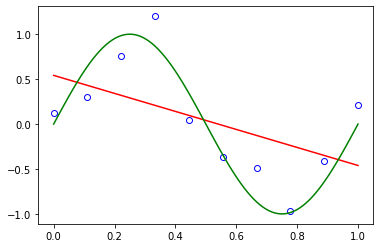

In [56]:
plot_x = tf.cast(tf.linspace(0.0, 1.0, 100), tf.float64)
design_mat = polynomial_basis_functions(plot_x, M)
plot_y = tf.linalg.matvec(design_mat, w_ML)

plt.plot(x, t, 'bo', markerfacecolor='none')
plt.plot(plot_x, plot_y, 'r')
plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')

print(w_ML[0])

In [0]:
x, t = create_toy_data(sinusoidal, 10, 0.25)
Ms = [1, 2, 4, 10]
w_ML = []
beta_ML = []
for M in Ms:
  design_mat = polynomial_basis_functions(x, M)
  pseudo_inverse = tf.linalg.matmul(
      tf.linalg.inv(tf.linalg.matmul(tf.transpose(design_mat), design_mat)),
      tf.transpose(design_mat))
  w = tf.linalg.matvec(pseudo_inverse, t)
  beta = 1. / tf.reduce_mean(
    tf.math.square(t - tf.linalg.matvec(design_mat, w)))
  w_ML.append(w)
  beta_ML.append(beta) # 식 3.12

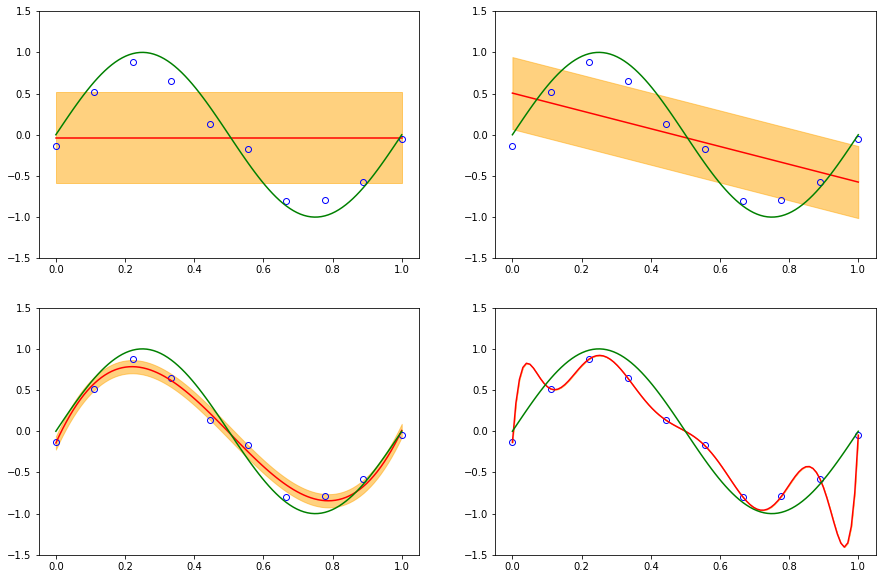

In [53]:
plt.figure(figsize=(15,10))
for i in range(len(w_ML)):
  w = w_ML[i]
  beta = beta_ML[i]
  target_std = tf.math.sqrt(1. / beta)

  plt.subplot(2, 2, i + 1)
  plot_x = tf.cast(tf.linspace(0.0, 1.0, 100), tf.float64)
  design_mat = polynomial_basis_functions(plot_x, len(w))
  plot_y = tf.linalg.matvec(design_mat, w)
  plt.plot(x, t, 'bo', markerfacecolor='none')
  plt.plot(plot_x, plot_y, 'r')
  plt.fill_between(
    plot_x, plot_y - target_std, plot_y + target_std,
    color="orange", alpha=0.5)
  plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')
  plt.ylim(-1.5,1.5)

### 3.1.4 Regularized least squares

$$
L = \frac{1}{2} \Sigma_{n=1}^{N} \{t_n - \textbf{w}^\text{T} \phi(\textbf{x}_n) \}^2 + \frac{\lambda}{2} \textbf{w}^\text{T}\textbf{w}
$$

$$
\textbf{w}_\text{ML} = (\lambda \textbf{I} + \mathbf{\Phi}^\text{T}\mathbf{\Phi})^{-1}\mathbf{\Phi}^\text{T} \mathsf{\bf{t}}
$$

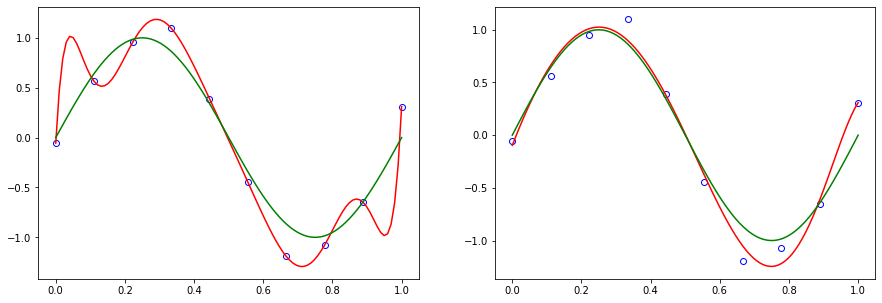

In [70]:
x, t = create_toy_data(sinusoidal, 10, 0.2)
M = 10
design_mat = polynomial_basis_functions(x, M)
pseudo_inverse = tf.linalg.matmul(
    tf.linalg.inv(tf.linalg.matmul(tf.transpose(design_mat), design_mat)),
    tf.transpose(design_mat))
w_ML = tf.linalg.matvec(pseudo_inverse, t)

lamb = 1.e-4
I = tf.eye(M, dtype=tf.float64)
w_LASSO = tf.linalg.matvec(
    tf.linalg.matmul(
        tf.linalg.inv(
            tf.add(
                lamb * I,
                tf.linalg.matmul(tf.transpose(design_mat), design_mat))), 
        tf.transpose(design_mat)), 
    t) # 식 3.28
list_w = [w_ML, w_LASSO]

plt.figure(figsize=(15,5))
for i, w in enumerate(list_w):
  plt.subplot(1, 2, i+1)
  plot_x = tf.cast(tf.linspace(0.0, 1.0, 100), tf.float64)
  design_mat = polynomial_basis_functions(plot_x, M)
  plot_y = tf.linalg.matvec(design_mat, w)

  plt.plot(x, t, 'bo', markerfacecolor='none')
  plt.plot(plot_x, plot_y, 'r')
  plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')


## 3.2. The Bias-Variance Decomposition

In [0]:
L = 100
M = 25
N = 25

D = []
for i in range(L):
  x, t = create_toy_data(sinusoidal, N, 0.2)
  D.append({'x':x, 't':t})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


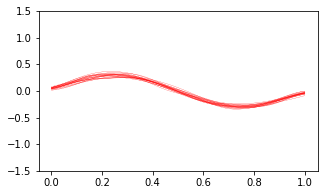

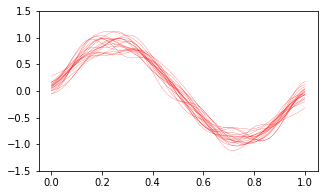

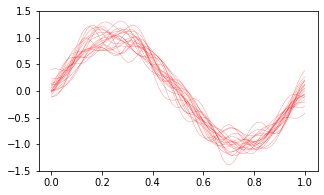

In [201]:
lamb_list = [np.exp(3.0), np.exp(0.0), np.exp(-3.0)]
for i, lamb in enumerate(lamb_list):
  plt.figure(figsize=(5,10))
  for l in range(20):
    x, t = D[l]['x'], D[l]['t']
    phi = gaussian_basis_functions(x, np.linspace(0, 1, M), 0.05)

    I = tf.eye(M, dtype=tf.float64)
    w = tf.linalg.matvec(
        tf.linalg.matmul(
            tf.linalg.inv(
                tf.add(
                    lamb * I,
                    tf.linalg.matmul(tf.transpose(phi), phi))), 
            tf.transpose(phi)), 
        t)
        
    plt.subplot(3, 1, i+1)
    plot_x = tf.cast(tf.linspace(0.0, 1.0, 100), tf.float64)
    phi = gaussian_basis_functions(plot_x, np.linspace(0, 1, M), 0.05)
    plot_y = tf.linalg.matvec(phi, w)

    plt.plot(plot_x, plot_y, 'r', linewidth=0.2)
    plt.ylim(-1.5,1.5)

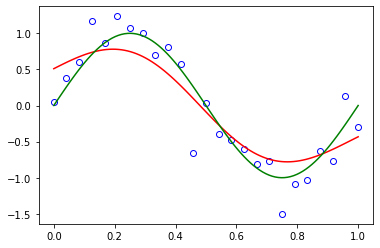

In [148]:
M = 25
x, t = create_toy_data(sinusoidal, M, 0.25)

design_mat = gaussian_basis_functions(x, np.linspace(0, 1, M), 0.2)
lamb = 10.0
I = tf.eye(M, dtype=tf.float64)
w = tf.linalg.matvec(
    tf.linalg.matmul(
        tf.linalg.inv(
            tf.add(
                lamb * I,
                tf.linalg.matmul(tf.transpose(design_mat), design_mat))), 
        tf.transpose(design_mat)), 
    t) # 식 3.28
    
plot_x = tf.cast(np.linspace(0, 1, 100), tf.float64)
design_mat = gaussian_basis_functions(plot_x, np.linspace(0, 1, M), 0.2)
plot_y = tf.linalg.matvec(design_mat, w)

plt.plot(x, t, 'bo', markerfacecolor='none')
plt.plot(plot_x, plot_y, 'r')
plt.plot(plot_x, tf.sin(2 * math.pi * plot_x), 'g')